# 1.Import Libraries

In [1]:
import os
import numpy as np
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception, NASNetMobile, DenseNet121
from tensorflow.keras.models import Model, load_model

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [4]:
from tf_keras_vis.gradcam import Gradcam
import shap
from tf_keras_vis import gradcam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input,  decode_predictions as decode_xception
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input, decode_predictions as decode_densenet
from tensorflow.keras.applications.nasnet import preprocess_input as  nasnet_preprocess_input, decode_predictions as decode_nasnet

# 2.Load Dataset and Apply Data Augmentation

In [5]:
Image_Size = 224
Batch_Size = 32
Channels = 3
Epochs = 20
data_dir = "C:\\Users\\manis\\OneDrive\\Desktop\\Data Science Plan\\Major Project\\balanced_ds"

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size = Batch_Size, image_size = (Image_Size, Image_Size), shuffle = True)

class_names = dataset.class_names
class_names

Found 13368 files belonging to 6 classes.


['Bacterial Spot',
 'Early Blight',
 'Healthy',
 'Late Blight',
 'Septoria Leaf Spot',
 'Yellow Leaf Curl Virus']

In [7]:
#type of the dataset
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [8]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.75, val_split=0.15, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 42)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_data, val_data, test_data = split_dataset(dataset)



In [9]:

train_aug = tf.keras.Sequential([
    tf.keras.layers.Resizing(Image_Size,Image_Size),
    tf.keras.layers.Rescaling(1.0/255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.01, 0.01),
    tf.keras.layers.RandomContrast(0.3)
])


test_aug = tf.keras.Sequential([
     tf.keras.layers.Resizing(Image_Size,Image_Size),
    tf.keras.layers.Rescaling(scale=1.0/255.0)])

In [10]:

train_data = train_data.map(lambda x, y: (train_aug(x, training=True), y))

val_data = val_data.map(lambda x, y: (test_aug(x), y))

test_data = test_data.map(lambda x, y: (test_aug(x), y))

print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :418 
Batch size of Training Data is :313
Batch size of Validation Data is :62 
Batch size of Testing Data is :43 


In [11]:

train_ds = train_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

# 3.Implementing GLCM feature extraction Method

In [25]:

#dfining the GLCM feature extraction function with distance 1 and at 90 degree pie is 180, normed is ture to nomalise the pixel values
#levels is 256 since the values range from 0 to 255 in grey image,
#symmetry is True - For the example above, it would also count how often a pixel with a value of 120 is followed by a pixel
#with a value of 100 at a distance of 1 pixel to the left.
#This effectively averages the occurrences in both directions, making the matrix more robust to directional biases.


def extract_glcm_features(image, distances=[1], angles=[np.pi/2], levels=256, symmetric=True, normed=True):
   #check if the dimension is 3 , GLCM has to convert to Garylevel 
    if image.ndim == 3:
        gray_image =  rgb2gray(image)
        
    gray_image = (gray_image * 255).astype('uint8')
#greycomatrix() function from the skimage.feature module to calculate a Gray-Level Co-occurrence Matrix (GLCM) for a given grayscale image    
    glcm = greycomatrix(gray_image, distances=distances, angles=angles, levels=levels, symmetric=symmetric, normed=normed)
    
  
    features = [] 
    for prop in ['contrast', 'energy', 'correlation']: 
        prop_values = greycoprops(glcm, prop) 
        features.extend(prop_values.flatten())  
    
    return features



# 4. Utilise Pre-trained Models

In [11]:

xception_model =  load_model('Xception_model.h5')
nasnet_model =  load_model('Nasnet_model.h5')
densenet_model = load_model('DenseNet121_model.h5')

In [24]:
def extract_features_with_glcm(model, dataset, batch_size):
    total_samples = dataset.cardinality().numpy() * batch_size# calculates the total number of samples in the dataset
    features = []
    labels = []
# this accesess each batch of the dataset ( a single batch has 32 images)
    for inputs, targets in dataset: 
        preds = model.predict(inputs, verbose =1)

       # ensure to eliminate the batches that do not have 32 images such as the last batch , to aavoid discrepency in strcuture
        if preds.shape[0] != batch_size:
            continue
# initialise a list to store glcm features foe each batch
        batch_glcm_features = []
    ##access each image from the batch
        for img in inputs:
            #extact the features
            glcm_features = extract_glcm_features(img.numpy())
            #append GLCM features of each image to the list
            batch_glcm_features.append(glcm_features)
        # a single batch (32 images) GLCM features are stores in form of array
        batch_glcm_features = np.array(batch_glcm_features)
        #combine the CNN features and GLCM features predistion in column wise stacking
        combined_features = np.hstack((preds, batch_glcm_features))

        #combine features in the list
        features.append(combined_features)
        #append the labels
        labels.append(targets.numpy())
        
        #if all the images in the dataset are processed then get out of the loop
        
        if len(features) * Batch_Size >= total_samples: 
            break 
#why are we doing the vstack ? Because in the previous part the features are stored in the format (batch_size , total Features)
# and the labels were(32,)
#it is a 2D array in the features 
#the vstack stakcs the features row wise as (total_samples, total features)
#the labels are represented as (total lables)
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

#Let's say you have 3 batches with 32 images each.
#features would be a list of 3 arrays, each with shape (32, total_features).
#np.vstack(features) would create a single array with shape (96, total_features).

#labels would be a list of 3 arrays, each with 32 labels.
#np.concatenate(labels) would create a single 1D array with 96 labels.

In [103]:

xception_train_features_glcm, train_labels = extract_features_with_glcm(xception_model, train_ds, Batch_Size)
nasnet_train_features_glcm = extract_features_with_glcm(nasnet_model, train_ds, Batch_Size)[0]
densenet_train_features_glcm = extract_features_with_glcm(densenet_model, train_ds, Batch_Size)[0]




xception_val_features_glcm, val_labels = extract_features_with_glcm(xception_model, val_ds, Batch_Size)
nasnet_val_features_glcm = extract_features_with_glcm(nasnet_model, val_ds, Batch_Size)[0]
densenet_val_features_glcm = extract_features_with_glcm(densenet_model, val_ds, Batch_Size)[0]



xception_test_features_glcm, test_labels = extract_features_with_glcm(xception_model, test_ds, Batch_Size)
densenet_test_features_glcm = extract_features_with_glcm(densenet_model, test_ds, Batch_Size)[0]
nasnet_test_features_glcm = extract_features_with_glcm(nasnet_model, test_ds, Batch_Size)[0]


1/1 [==============================] - 1s 709ms/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 433ms/step


In [113]:

stacked_train_features_glcm = np.hstack([xception_train_features_glcm, nasnet_train_features_glcm, densenet_train_features_glcm])

stacked_val_features_glcm = np.hstack([xception_val_features_glcm, nasnet_val_features_glcm,densenet_val_features_glcm ])

stacked_test_features_glcm = np.hstack([xception_test_features_glcm, nasnet_test_features_glcm,densenet_test_features_glcm])

In [115]:

np.save("stacked_train_features_glcm.npy", stacked_train_features_glcm)
np.save("stacked_val_features_glcm.npy", stacked_val_features_glcm)
np.save("stacked_test_features_glcm.npy", stacked_test_features_glcm)


np.save("train_labels_glcm.npy", train_labels)
np.save("val_labels_glcm.npy", val_labels)
np.save("test_labels_glcm.npy", test_labels)

In [12]:


stacked_train_features_glcm = np.load("stacked_train_features_glcm.npy")
stacked_val_features_glcm = np.load("stacked_val_features_glcm.npy")
stacked_test_features_glcm = np.load("stacked_test_features_glcm.npy")


train_labels = np.load("train_labels_glcm.npy")
val_labels = np.load("val_labels_glcm.npy")
test_labels = np.load("test_labels_glcm.npy")


# 5.Train XGB boost classifier

In [13]:

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(stacked_train_features_glcm,train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

In [14]:

val_preds = xgb.predict(stacked_val_features_glcm)
accuracy = np.mean(val_preds == val_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
# mean is used here to calculate the accurate predictions
#True is 1
#False is 0

Validation Accuracy: 93.40%


In [15]:

test_preds = xgb.predict(stacked_test_features_glcm)
accuracy = np.mean(test_preds == test_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 94.04%


# 6. Performance Metrics

Accuracy on test set: 0.940406976744186


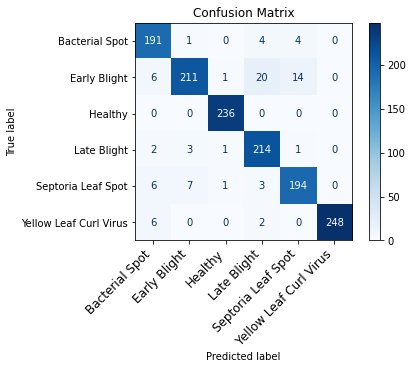

In [16]:
cm = confusion_matrix(test_labels, test_preds)

accuracy = accuracy_score(test_labels, test_preds)
print("Accuracy on test set:", accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)  
disp.plot(cmap=plt.cm.Blues)
plt.xticks(fontsize=12, rotation=45, ha="right")
plt.title("Confusion Matrix")
plt.show()

In [17]:

print(classification_report(test_labels, test_preds, target_names=class_names))

                        precision    recall  f1-score   support

        Bacterial Spot       0.91      0.95      0.93       200
          Early Blight       0.95      0.84      0.89       252
               Healthy       0.99      1.00      0.99       236
           Late Blight       0.88      0.97      0.92       221
    Septoria Leaf Spot       0.91      0.92      0.92       211
Yellow Leaf Curl Virus       1.00      0.97      0.98       256

              accuracy                           0.94      1376
             macro avg       0.94      0.94      0.94      1376
          weighted avg       0.94      0.94      0.94      1376



# 7. Random Search to Optimize 

In [122]:

param_dist = {
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(200, 600),
    'gamma': uniform(0, 5),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

In [123]:

xg_boost = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

random_search = RandomizedSearchCV(
    estimator=xg_boost,
    param_distributions=param_dist,
    cv=5,               
    scoring='accuracy',  
    verbose=1,          
    n_jobs=-1            
)



random_search.fit(stacked_train_features_glcm,train_labels)


print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)


best_model = random_search.best_estimator_
y_pred = best_model.predict(stacked_test_features_glcm)
print("Test Set Accuracy:", accuracy_score(test_labels, y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'colsample_bytree': 0.9342641113861598, 'gamma': 3.039377211347238, 'learning_rate': 0.09125580079353328, 'max_depth': 11, 'n_estimators': 476, 'subsample': 0.5650122012629761}
Best Cross-Validation Accuracy: 0.950821322163606
Test Set Accuracy: 0.9367732558139535


# 8. Interpretability of the xgboost model

## a. Implement Gradcam to understand the interpretability of CNN models

In [18]:

def preprocess_image(img_path,model_type, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)# expanding the dimension beacuse it has to incoprtorate the batch size possition so it will be (1,)
    if model_type == 'xception':
        img_array = xception_preprocess_input(img_array)
    elif model_type == 'densenet':
        img_array = densenet_preprocess_input(img_array)
    elif model_type == 'nasnet':
        img_array = nasnet_preprocess_input(img_array)

    return img_array


In [19]:

class GradCAM:
    def __init__(self, model, layer_name, decode_predictions_fn):
        self.model = model
        self.layer_name = layer_name 
        self.decode_predictions_fn = decode_predictions_fn 
        self.grad_model = Model( 
            inputs=model.inputs,
            outputs=[model.get_layer(layer_name).output, model.output]
        )

    def predict_class(self, img_array):
        predictions = self.model.predict(img_array)  # making predictions 
        class_index = np.argmax(predictions[0])    # finding the class index for the highest prediction
        confidence = predictions[0][class_index] # finding the confidence value for the prediction   
        class_label = class_names[class_index]      # displaying the class name based on the class index.
        
        return class_label, confidence
    
    def compute_heatmap(self, img_array, class_index=None):
        with tf.GradientTape() as tape:
            #Extracts the output of a specific convolutional layer (conv_outputs).
#Makes a prediction for the input image (img_array).
            conv_outputs, predictions = self.grad_model(img_array) 
            if class_index is None:
                class_index = np.argmax(predictions[0])# determines the predicted class if not already given
            loss = predictions[:, class_index] #predicted probability score for the specified class_index
#This is where cre gradiation happens  calculates the gradients of the loss with respect to the conv_outputs
        grads = tape.gradient(loss, conv_outputs) 
      
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

       
        conv_outputs = conv_outputs[0]
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

      
        heatmap = np.maximum(heatmap, 0)#This line ensures that all values in the heatmap are non-negative.
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1 #This line normalizes the heatmap by dividing each value by the maximum value in the heatmap.

        return heatmap

    def overlay_heatmap(self, img_path, heatmap, alpha=0.5):
    
        original_img = Image.open(img_path).resize((224, 224))
        heatmap_resized = Image.fromarray(np.uint8(255 * heatmap)).resize(original_img.size)
        heatmap_resized = np.array(heatmap_resized)

 
        colormap = plt.cm.jet(heatmap_resized / 255.0)[:, :, :3]
        colormap = np.uint8(255 * colormap)

  
        overlay = Image.blend(original_img.convert("RGBA"), Image.fromarray(colormap).convert("RGBA"), alpha)
        return overlay


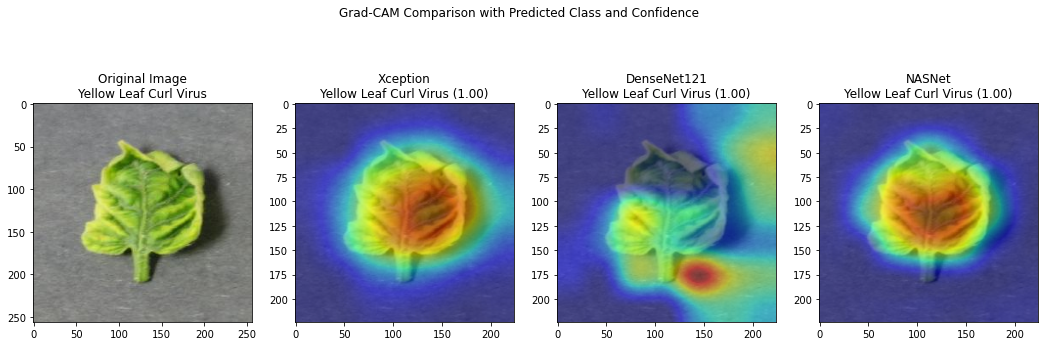

In [20]:

img_path = 'C:\\Users\\manis\\OneDrive\\Desktop\\Data Science Plan\\Major Project\\balanced_ds\\Yellow Leaf Curl Virus\\YLC2.JPG'
disease_name = img_path.split('\\')[-2]
original_img = Image.open(img_path)

# to show the Grad-CAM visulaization for the last convolutional layer
gradcam_xception = GradCAM(xception_model, layer_name='block14_sepconv2_act', decode_predictions_fn=decode_xception)
gradcam_densenet = GradCAM(densenet_model, layer_name='conv5_block16_2_conv', decode_predictions_fn=decode_densenet)
gradcam_nasnet = GradCAM(nasnet_model, layer_name='activation_187', decode_predictions_fn=decode_nasnet)


xception_img = preprocess_image(img_path, model_type='xception')
densenet_img = preprocess_image(img_path, model_type='densenet')
nasnet_img = preprocess_image(img_path, model_type='nasnet')


xception_class, xception_conf = gradcam_xception.predict_class(xception_img)
densenet_class, densenet_conf = gradcam_densenet.predict_class(densenet_img)
nasnet_class, nasnet_conf = gradcam_nasnet.predict_class(nasnet_img)


heatmap_xception = gradcam_xception.compute_heatmap(xception_img)
heatmap_densenet = gradcam_densenet.compute_heatmap(densenet_img)
heatmap_nasnet = gradcam_nasnet.compute_heatmap(nasnet_img)


overlay_xception = gradcam_xception.overlay_heatmap(img_path, heatmap_xception)
overlay_densenet = gradcam_densenet.overlay_heatmap(img_path, heatmap_densenet)
overlay_nasnet = gradcam_nasnet.overlay_heatmap(img_path, heatmap_nasnet)

fig, axs = plt.subplots(1, 4, figsize=(18, 6))

axs[0].imshow(original_img)
axs[0].set_title(f'Original Image\n{disease_name}')

axs[1].imshow(overlay_xception)
axs[1].set_title(f'Xception\n{str(xception_class).title()} ({xception_conf:.2f})')

axs[2].imshow(overlay_densenet)
axs[2].set_title(f'DenseNet121\n{str(densenet_class).title()} ({densenet_conf:.2f})')

axs[3].imshow(overlay_nasnet)
axs[3].set_title(f'NASNet\n{str(nasnet_class).title()} ({nasnet_conf:.2f})')


plt.suptitle('Grad-CAM Comparison with Predicted Class and Confidence')
plt.show()


# b. Interpretability for only GLCM features across each class

In [26]:
def extract_glcm_features_only(dataset, batch_size):
    total_samples = dataset.cardinality().numpy() * batch_size
    features = []
    labels = []

    for inputs, targets in dataset: 
        batch_glcm_features = []

        for img in inputs:  
            glcm_features = extract_glcm_features(img.numpy()) 
            batch_glcm_features.append(glcm_features)
        
        batch_glcm_features = np.array(batch_glcm_features) 
        
        features.append(batch_glcm_features)
        labels.append(targets.numpy()) 
        
     
        if len(features) * batch_size >= total_samples:
            break

    features = np.vstack(features) 
    labels = np.concatenate(labels)  
    return features, labels

batch_size = Batch_Size 
train_glcm_features_only, train_glcm_labels = extract_glcm_features_only(train_ds, batch_size)
test_glcm_features_only, test_glcm_labels = extract_glcm_features_only(test_ds, batch_size)
print("GLCM Features Shape:", train_glcm_features_only.shape)
print("Labels Shape:", train_glcm_labels.shape)


GLCM Features Shape: (10016, 3)
Labels Shape: (10016,)


In [26]:
xgb_glcm = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_glcm.fit(train_glcm_features_only,train_glcm_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

#### The SHAP values (x-axis) represent the impact of a feature on the model's output. Positive values indicate an increase in the model's output, while negative values indicate a decrease.
#### The red values indicate high values of the feature and blue indicate low values of the feature


100%|===================| 60044/60048 [38:28<00:00]        

Summary plot for class Bacterial Spot


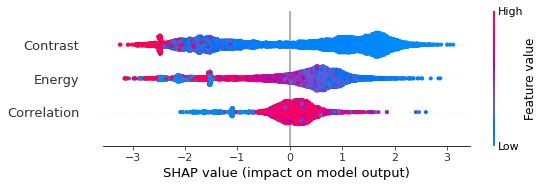

Summary plot for class Early Blight


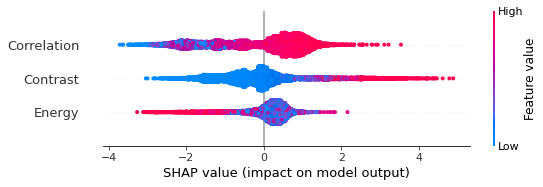

Summary plot for class Healthy


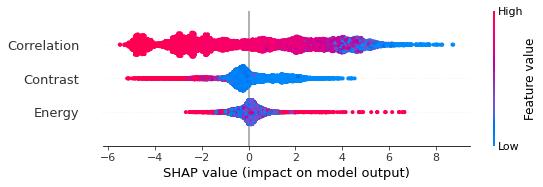

Summary plot for class Late Blight


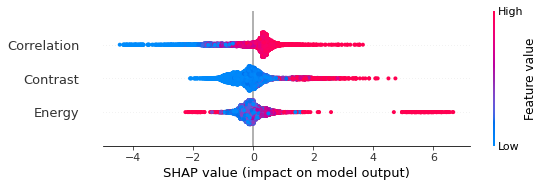

Summary plot for class Septoria Leaf Spot


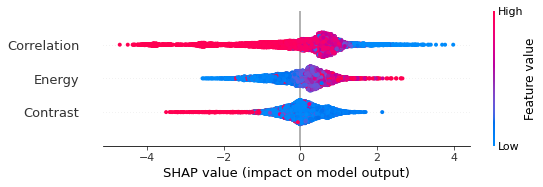

Summary plot for class Yellow Leaf Curl Virus


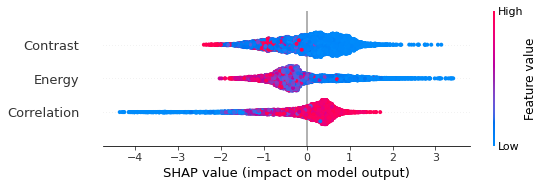

In [27]:
#initializing the shap explainer 
explainer_glcm = shap.Explainer(xgb_glcm, train_glcm_features_only)

#This calculates SHAP values for the model's predictions on the training data
#SHAP values explain the contribution of each feature to the model's output for every sample in the dataset.
shap_values_glcm = explainer_glcm(train_glcm_features_only)

#shap.summary_plot visualizes the SHAP values for the specific class.
num_classes = len(class_names)
feature_names = ["Contrast", "Energy", "Correlation"]

for class_index in range(num_classes):
    print(f"Summary plot for class {class_names[class_index]}")
    shap_values_class = shap_values_glcm[:, :, class_index]
    shap.summary_plot(shap_values_class, train_glcm_features_only, feature_names=feature_names)


## c. Implement SHAP to understand the interpretability of the ensemble model with GLCM features

In [27]:

def preprocess_image(img_path,model_type, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    if model_type == 'xception':
        img_array = xception_preprocess_input(img_array)
    elif model_type == 'densenet':
        img_array = densenet_preprocess_input(img_array)
    elif model_type == 'nasnet':
        img_array = nasnet_preprocess_input(img_array)

    return img_array



xcep_img_array = preprocess_image(img_path,'xception')
dense_img_array = preprocess_image(img_path,'densenet')
nas_img_array = preprocess_image(img_path,'nasnet')# Preprocess the image appropriately



In [28]:
def extract_features_with_glcm_single(model, img_array, target_size=(224,224)):
    features = []
    glcm=[]
   
    
    preds = model.predict(img_array, verbose=1)
   
    reshaped_image = img_array[0]  

    glcm_features = extract_glcm_features(reshaped_image)

    combined_features = np.hstack((preds.flatten(), glcm_features))

    features.append(combined_features)

    features = np.array(features)
    
    return features

xception_features = extract_features_with_glcm_single(xception_model, xcep_img_array)
densenet_features = extract_features_with_glcm_single(densenet_model, dense_img_array)
nasnet_features = extract_features_with_glcm_single(nasnet_model, nas_img_array)

stacked_input =  np.hstack([xception_features, densenet_features, nasnet_features])


1/1 [==============================] - 0s 127ms/step


In [31]:
xception_features

array([[3.90089667e-08, 2.36188680e-05, 6.77970602e-05, 8.14902251e-06,
        8.47634965e-06, 9.99891877e-01, 9.53181941e+03, 2.75337332e-02,
        5.24056256e-01]])

In [32]:
densenet_features

array([[2.41591867e-08, 1.45232718e-07, 5.75089416e-07, 1.57982358e-04,
        3.21512671e-05, 9.99809086e-01, 3.33965545e+03, 1.94858223e-02,
        5.59469757e-01]])

In [30]:
stacked_input

array([[3.90089667e-08, 2.36188680e-05, 6.77970602e-05, 8.14902251e-06,
        8.47634965e-06, 9.99891877e-01, 9.53181941e+03, 2.75337332e-02,
        5.24056256e-01, 2.41591867e-08, 1.45232718e-07, 5.75089416e-07,
        1.57982358e-04, 3.21512671e-05, 9.99809086e-01, 3.33965545e+03,
        1.94858223e-02, 5.59469757e-01, 1.15270668e-04, 1.73491635e-03,
        5.61099796e-06, 8.92159063e-04, 2.69638622e-05, 9.97225046e-01,
        9.53181941e+03, 2.75337332e-02, 5.24056256e-01]])

In [29]:
xgb_pred = xgb.predict(stacked_input)
class_names[xgb_pred[0]]

'Yellow Leaf Curl Virus'

In [28]:

explainer = shap.Explainer(xgb, stacked_train_features_glcm)
shap_values = explainer(stacked_input) 

Waterfall plot for Class Bacterial Spot


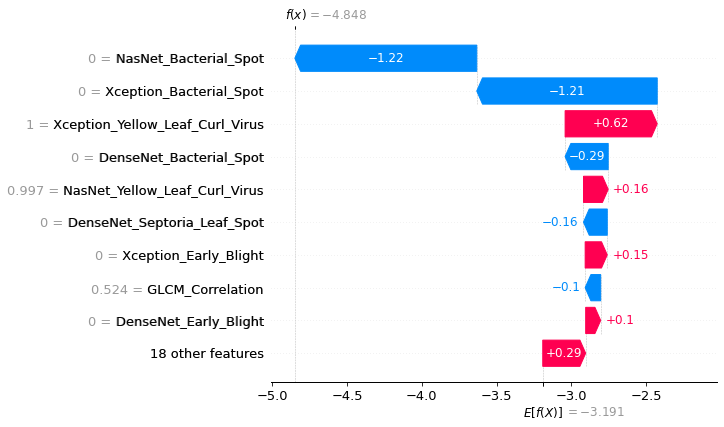

Waterfall plot for Class Early Blight


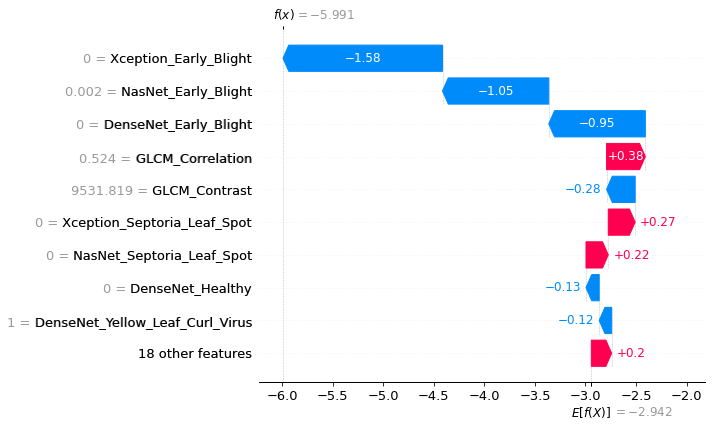

Waterfall plot for Class Healthy


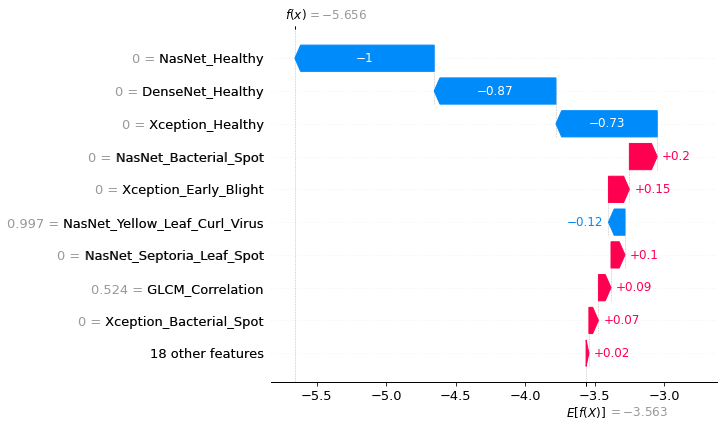

Waterfall plot for Class Late Blight


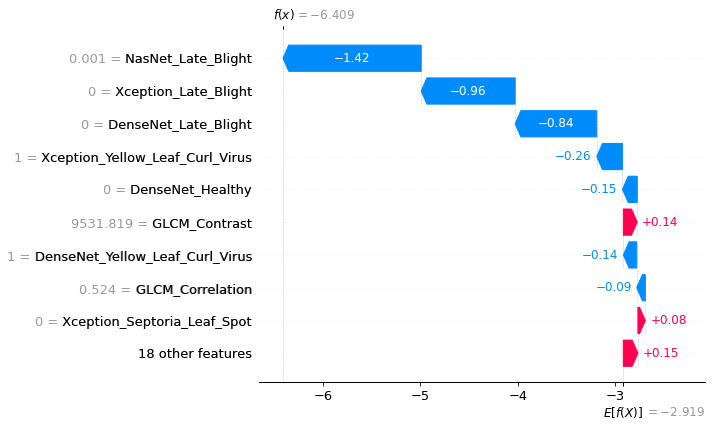

Waterfall plot for Class Septoria Leaf Spot


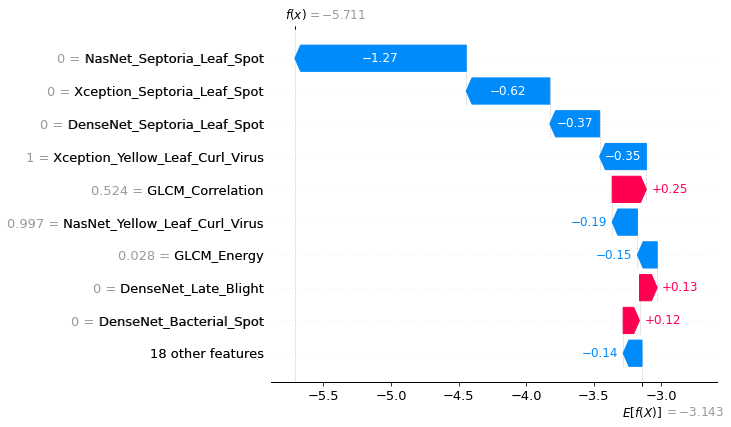

Waterfall plot for Class Yellow Leaf Curl Virus


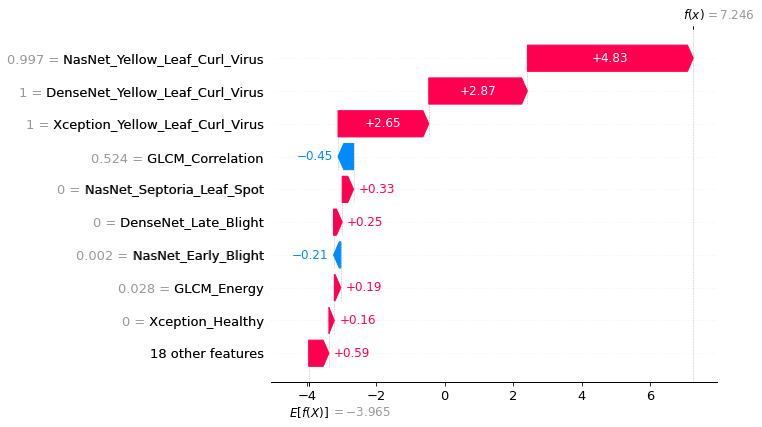

In [30]:
feature_names = [
    "Xception_Bacterial_Spot", "Xception_Early_Blight", "Xception_Healthy", "Xception_Late_Blight", "Xception_Septoria_Leaf_Spot", "Xception_Yellow_Leaf_Curl_Virus",
    "GLCM_Contrast", "GLCM_Energy" , "GLCM_Correlation",
    "DenseNet_Bacterial_Spot", "DenseNet_Early_Blight", "DenseNet_Healthy", "DenseNet_Late_Blight", "DenseNet_Septoria_Leaf_Spot", "DenseNet_Yellow_Leaf_Curl_Virus",
    "GLCM_Contrast", "GLCM_Energy" , "GLCM_Correlation",
    "NasNet_Bacterial_Spot", "NasNet_Early_Blight", "NasNet_Healthy", "NasNet_Late_Blight", "NasNet_Septoria_Leaf_Spot", "NasNet_Yellow_Leaf_Curl_Virus",
    "GLCM_Contrast", "GLCM_Energy" , "GLCM_Correlation"
]

base_values = shap_values.base_values[0]  
values = shap_values.values[0]            
data = shap_values.data[0]                

for class_index in range(6):
    print(f"Waterfall plot for Class {class_names[class_index]}")
    
   
    shap_explanation_class = shap.Explanation(
        values=values[:, class_index],    
        base_values=base_values[class_index],  
        data=data,                        
        feature_names=feature_names
    )
    
    shap.waterfall_plot(shap_explanation_class)


The plot visualizes the interaction effects between features on model predictions
The red and blue colors indicate the feature value ranges:
Red: High feature values.
Blue: Low feature values.
    
When a feature is interacting with itself (e.g., Feature 2 interacting with Feature 2), the plot captures the direct feature contribution to the model prediction.
These cells capture the pairwise feature interactions (e.g., Feature 2 interacting with Feature 5).
Some feature pairs have strong interaction effects on the model’s predictions (e.g., noticeable wider spreads or clear separation between red and blue).

100%|===================| 59876/59904 [10:30<00:00]        

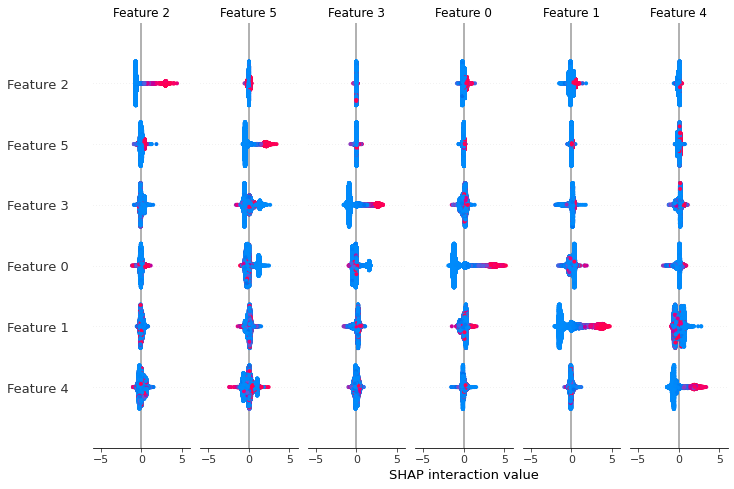

In [147]:



explainer = shap.Explainer(xgb, stacked_train_features_glcm)


shap_values = explainer(stacked_train_features_glcm)


shap.summary_plot(shap_values, stacked_train_features_glcm)
